# X To A Testis 1

In [21]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot
from larval_gonad.config import memory
from larval_gonad.x_to_a import CHROMS_CHR, AUTOSOMES_CHR, commonly_expressed, multi_chrom_boxplot

# Setup notebook
nbconfig = Nb.setup_notebook('2018-03-27_x2a_testis1', seurat_dir='../output/testis1_scRNAseq')

last updated: 2018-03-28 
Git hash: 44255e783d8cd88b58e53e268a122fc8548c416c


In [20]:
clusters = nbconfig.seurat.get_clusters()
clus6 = clusters['res.0.6']
tsne = nbconfig.seurat.get_tsne()

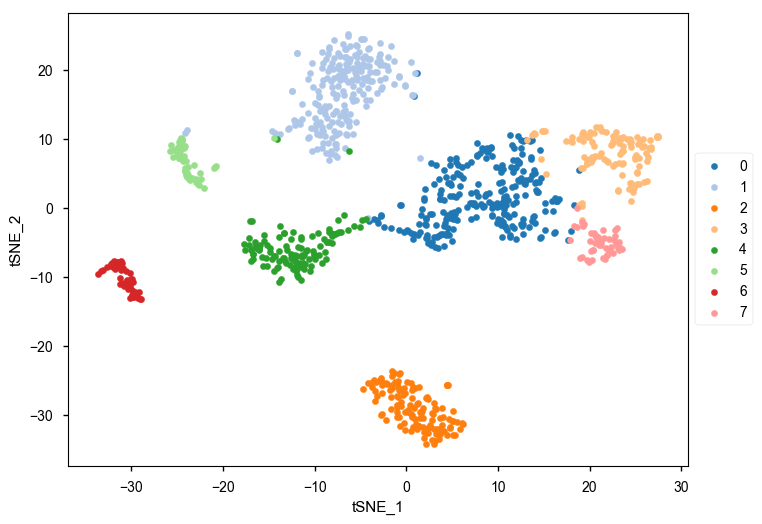

In [24]:
TSNEPlot('tSNE_1', 'tSNE_2', tsne.join(clus6), hue='res.0.6', cmap=sns.color_palette('tab20', n_colors=8))

# House Keeping

In [12]:
norm = nbconfig.seurat.get_normalized_read_counts()

In [13]:
print(norm.shape)
norm.head()

(11689, 1000)


,AAACCTGGTTCATGGT,AAACGGGAGACTGGGT,AAACGGGGTGTTAAGA,AAAGATGAGTATCGAA,AAAGATGAGTGGTAGC,AAAGATGCAAACCCAT,AAAGATGGTAGCGTGA,AAAGCAACAGCTCGCA,AAAGCAACAGGCTGAA,AAAGCAAGTCTAGGTT,...,TTGTAGGAGTACACCT,TTTACTGGTAATCACC,TTTATGCAGGAGTCTG,TTTATGCTCAACGCTA,TTTCCTCTCCCTAACC,TTTGGTTAGGTACTCT,TTTGGTTCATTTCAGG,TTTGGTTTCGTTGACA,TTTGTCAAGAGTAAGG,TTTGTCAAGCGTCAAG
FBgn,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000
FBgn0031085,1.426971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.116528,0.000000,...,0.0,0.0,0.0,1.674556,0.0,1.011521,1.471228,0.0,0.11752,0.000000
FBgn0040784,1.749042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.968886,1.464002,...,0.0,0.0,0.0,1.580837,0.0,0.000000,0.000000,0.0,0.00000,0.643912
FBgn0031086,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000
FBgn0031082,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.585381,0.0,0.000000,0.000000,0.0,0.00000,0.000000


In [14]:
expressed = commonly_expressed(norm)
len(expressed)

1544

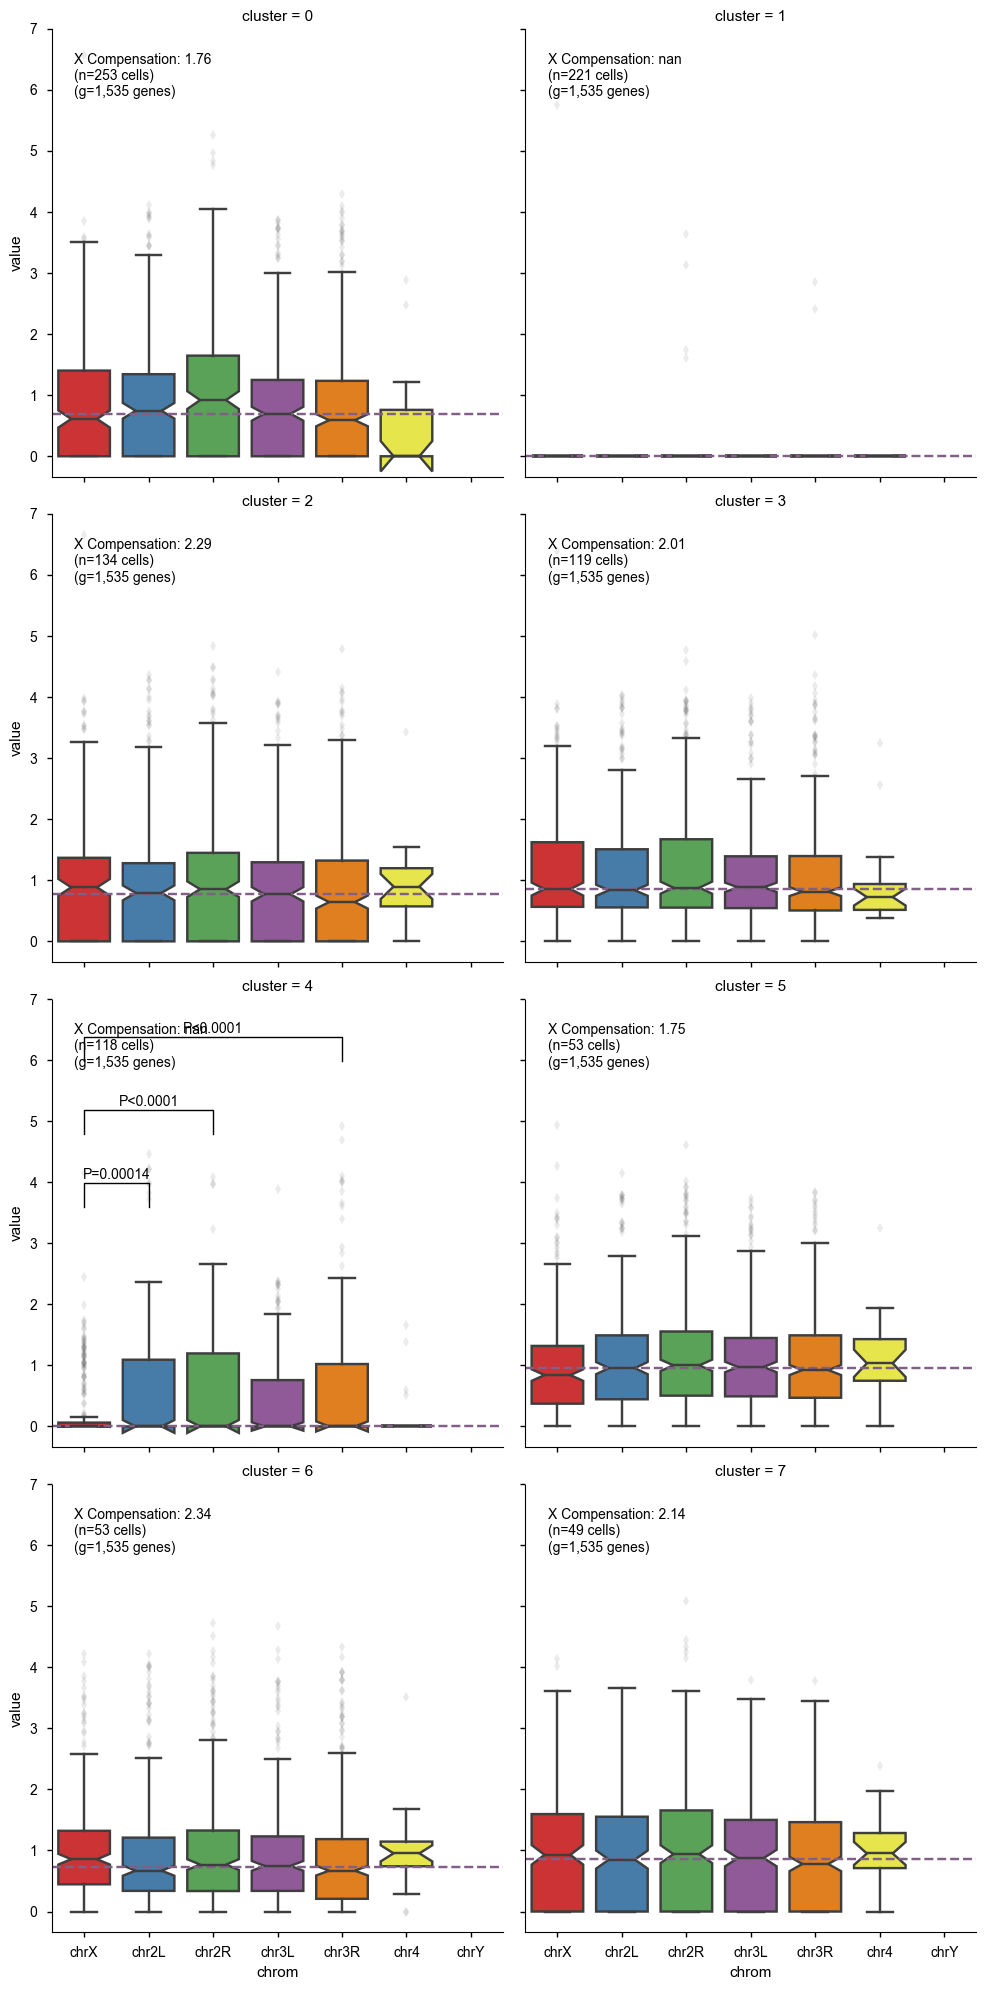

In [15]:
data = norm.loc[expressed, :].T.join(clus6)
data.rename({'res.0.6': 'cluster'}, axis=1, inplace=True)
dat = data.groupby('cluster').median().T.reset_index()\
    .melt(id_vars='index')\
    .merge(nbconfig.fbgn2chrom, left_on='index', right_index=True)\
    .set_index('index')

def _plot(dat):
    mpl.rcParams['pdf.fonttype'] = 42
    num_cells = data.groupby('cluster').count().iloc[:, 0].to_dict()
    g = sns.FacetGrid(dat, col='cluster', col_wrap=2, size=5)
    g.map_dataframe(multi_chrom_boxplot, 'chrom', 'value', num_cells=num_cells, palette=nbconfig.color_chrom, 
                    notch=True, flierprops=nbconfig.fliersprops)

_plot(dat)

In [16]:
Ydata = norm.join(nbconfig.fbgn2chrom).query('chrom == "chrY"').drop('chrom', axis=1)
Ydata = Ydata.T.loc[clus6.sort_values().index]

In [17]:
Ydata.columns = Ydata.columns.map(lambda x: nbconfig.fbgn2symbol[x])

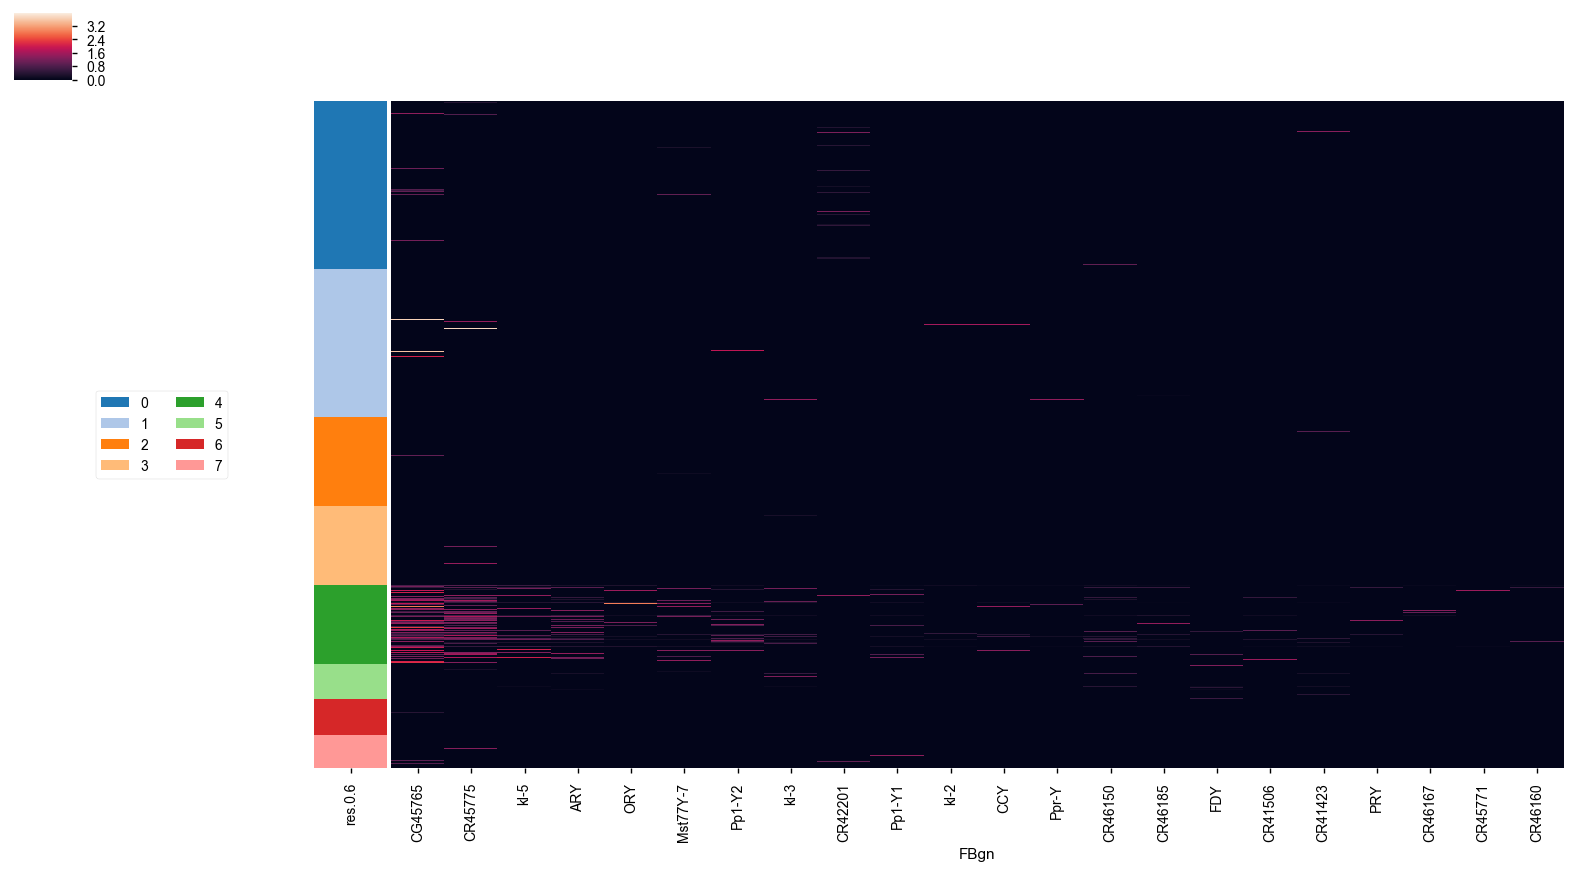

In [19]:
levels = sorted(clus6.unique())
colors = sns.color_palette('tab20', n_colors=len(levels))
mapper = dict(zip(levels, colors))
cmap = clus6.sort_values().map(mapper)

g = sns.clustermap(Ydata, row_cluster=False, col_cluster=True, yticklabels=False, row_colors=cmap, figsize=(20, 10))
g.ax_col_dendrogram.set_visible(False)

for label in levels:
    g.ax_row_dendrogram.bar(0, 0, color=mapper[label],
                            label=label, linewidth=0)
g.ax_row_dendrogram.legend(loc="center", ncol=2)

In [14]:
soma = clus12[clus12 == 13].index.tolist()
early = clus12[clus12 == 8].index.tolist()
late = clus12[clus12 == 6].index.tolist()

In [15]:
from larval_gonad.x_to_a import estimate_dcc, clean_pvalue

In [16]:
from scipy.stats import mannwhitneyu

In [37]:
def boxplot(data, expressed, mask, chrom, ax, name):
    _data = data.loc[expressed, mask]
    _data['median'] = _data.median(axis=1)
    _data = _data.join(chrom, how='inner')
    med_x, med_major, prop_dcc = estimate_dcc('chrom', 'median', _data)

    _data['chrom'] = _data['chrom'].map(lambda x: x.replace('chr', ''))
    
    ORDER = ['X', '2L', '2R', '3L', '3R', '4']
    sns.boxplot(_data['chrom'], _data['median'], order=ORDER, notch=True, boxprops={"facecolor": 'w'}, ax=ax, flierprops={'alpha': .6})
    ax.axhline(med_major, ls=':', lw=2, color=nbconfig.color_c1)
    ax.set_title(name)
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Median Normalized Expression')
    
    # Clean up the pvalue for plotting
    pvalues = {}
    iqr = 0
    chromX = _data[_data.chrom == 'X']
    for g, df in _data.groupby('chrom'):
        _iqr = sns.utils.iqr(df['median'])
        if _iqr > iqr:
            iqr = _iqr
        if g == 'X':
            continue
        if g == 'M':
            continue
        _, pval = mannwhitneyu(chromX['median'], df['median'], alternative='two-sided')
        if pval <= 0.001:
            pvalues[g] = '***'

    multiplier = .35
    xloc = ORDER.index('X')
    for k, v in pvalues.items():
        oloc = ORDER.index(k)
        pval = v
        y, h, col = iqr + iqr * multiplier, .1, 'k'
        plt.plot([xloc, xloc, oloc, oloc], [y, y+h, y+h, y], lw=1, c=col)
        plt.text((xloc+oloc)*.5, y+h+.01, f"{pval}", ha='center',
                 va='bottom', color=col)
        multiplier += .2

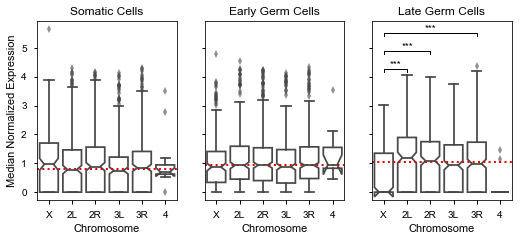

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.5, 3.3), sharex=True, sharey=True)
chrom = nbconfig.fbgn2chrom
boxplot(norm, expressed, soma, chrom, ax1, 'Somatic Cells')
boxplot(norm, expressed, early, chrom, ax2, 'Early Germ Cells')
boxplot(norm, expressed, late, chrom, ax3, 'Late Germ Cells')
ax2.set_ylabel('')
ax3.set_ylabel('')
plt.savefig('../output/figures/2018-03-16_x2a_combined_forced_simple_boxplot.png', dpi=300)
